# Project 5 - Part B (Continues after Part A)
### Image Warping and Mosaicing
Romil Bhardwaj

In [2]:
import csv
import math
import numpy as np
import pandas as pd
import skimage
import skimage.io as skio
import matplotlib.pyplot as plt
from matplotlib import animation
from numpy.linalg import LinAlgError
from scipy.spatial.qhull import Delaunay
from skimage.draw import draw
from skimage.transform import rescale, resize, downscale_local_mean
import os
import glob
import random

# Part A
### Methods to read images and annotated kyepoints

In [56]:
def read_keypoints(csv_path):
    with open(csv_path, 'r') as f:
        return np.array([list(map(float,rec)) for rec in csv.reader(f, delimiter=',')])

def read_img_and_keypoints(img_path, target_res=None, csv_suffix=""):
    img = skio.imread(img_path)

    img_filename = os.path.splitext(os.path.basename(img_path))[0]
    csv_path = os.path.join(os.path.dirname(img_path), f'{img_filename}{csv_suffix}.csv')

    keypoints = read_keypoints(csv_path)
    if target_res:
        target_x, target_y = target_res
        current_x, current_y, _ = img.shape
        x_rescale = target_x/current_x
        y_rescale = target_y/current_y
        # Resize image:
        img = resize(img, (target_y, target_x), anti_aliasing=True)
        # Resize keypoints:
        keypoints[:,0] *= x_rescale
        keypoints[:,1] *= y_rescale
    return img, keypoints

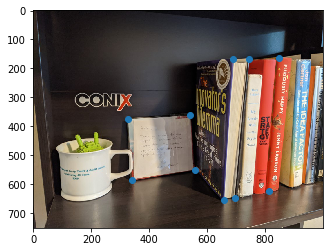

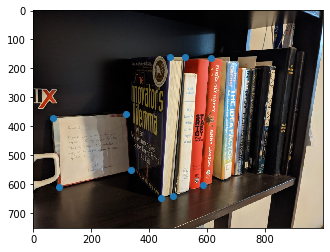

In [57]:
# Test iamge reading and keypoints
img1, kps1 = read_img_and_keypoints('imgs/shelf1.jpg')

plt.imshow(img1)
plt.scatter(x=kps1[:,0], y=kps1[:,1])
plt.savefig('outputs/annotated_eg1.jpg', bbox_inches='tight')

plt.figure()
img2, kps2 = read_img_and_keypoints('imgs/shelf2.jpg')
plt.imshow(img2)
plt.scatter(x=kps2[:,0], y=kps2[:,1])
plt.savefig('outputs/annotated_eg2.jpg', bbox_inches='tight')

## Compute homography


In [58]:
def get_coeff_row(p1, p2):
    return np.array([[-p2[0], -p2[1], -1, 0, 0, 0, p2[0]*p1[0], p2[1]*p1[0]],
                    [0, 0, 0, -p2[0], -p2[1], -1, p2[0]*p1[1], p2[1]*p1[1]]])
    return top

def compute_homography(pts1, pts2):
    assert pts1.shape[0] == pts2.shape[0]
    num_pts = pts1.shape[0]
    out_mat = np.expand_dims(-1*pts1.flatten(), axis=1)
    coeff_rows = []
    for i in range(0, num_pts):
        coeff_rows.append(get_coeff_row(pts1[i, :], pts2[i, :]))
    coeff_mat = np.vstack(coeff_rows)

    H_arr = (np.linalg.lstsq(coeff_mat, out_mat)[0]).T[0]
    H = np.array([[H_arr[0], H_arr[1], H_arr[2]],
                  [H_arr[3], H_arr[4], H_arr[5]],
                   [H_arr[6], H_arr[7], 1.]])
    return H

## Warping functions

In [59]:
def get_canvas_dim(im1_shape, im2_shape, H):
    trf_max_x, trf_max_y, trf_min_x, trf_min_y = get_bbox(im2_shape, H)
    max_x = max(trf_max_x, im1_shape[1], im2_shape[1])
    max_y = max(trf_max_y, im1_shape[0], im2_shape[0])
    return max_x, max_y, trf_min_x, trf_min_y

def get_bbox(target_shape, H):
    y_max, x_max = target_shape[0], target_shape[1]

    edges = [np.array([[0], [y_max], [1]]),
             np.array([[x_max], [y_max], [1]]),
             np.array([[0], [0], [1]]),
             np.array([[x_max], [0], [1]])]
    new_edges = []
    for point in edges:
        transformed_pt = np.matmul(H, point)
        transformed_pt = transformed_pt/transformed_pt[-1]
        new_edges.append(transformed_pt)
    new_edges = np.array(new_edges, dtype=np.int).squeeze()
    new_edges = np.delete(new_edges, 2, 1)  # Remove 1s

    trf_max_x, trf_max_y = np.max(new_edges, axis=0)
    trf_min_x, trf_min_y = np.min(new_edges, axis=0)

    return trf_max_x, trf_max_y, trf_min_x, trf_min_y

def get_mask_shape(im1_shape, im2_shape, H):
    max_x, max_y, min_x, min_y = get_canvas_dim(im1_shape, im2_shape, H)
    colmask, rowmask = draw.polygon([0, max_x + abs(min_x), max_x + abs(min_x), 0],
                        [0, 0, max_y + abs(min_y), max_y + abs(min_y)])
    return colmask, rowmask

def get_mask(im1_shape, im2_shape, H):
    colmask, rowmask = get_mask_shape(im1_shape, im2_shape, H)
    mask_mult = np.array(np.vstack([colmask, rowmask, np.ones(len(colmask))]))
    mask_trf = np.matmul(np.linalg.inv(H), mask_mult)
    colmask_trf, rowmask_trf, z_trf = np.squeeze(mask_trf[0]), np.squeeze(mask_trf[1]), np.squeeze(mask_trf[2])
    colmask_trf = (colmask_trf / z_trf).astype(np.int)
    rowmask_trf = (rowmask_trf / z_trf).astype(np.int)
    return colmask_trf, rowmask_trf, mask_mult

def get_canvas(im1_shape, im2_shape, H):
    max_x, max_y, min_x, min_y = get_canvas_dim(im1_shape, im2_shape, H)
    return np.zeros((max_y + abs(min_y) + 1, max_x + abs(min_x) + 1, 3)).astype(np.int)

def get_target_idxs(valid_indices, mask, im2_shape, H):
    max_x, max_y, min_x, min_y = get_bbox(im2_shape, H)
    offset_x = abs(min(min_x, 0))
    offset_y = abs(min(min_y, 0))
    targets_x = np.squeeze(np.asarray(mask[0], dtype=np.int))[valid_indices]
    targets_y = np.squeeze(np.asarray(mask[1], dtype=np.int))[valid_indices]
    targets_x += offset_x
    targets_y += offset_y

    return offset_x, offset_y, targets_x, targets_y

def get_alpha_mask(im1_shape):
    img_half = int(im1_shape[1]/2)
    # Alpha: Ones for the first half, linearly fall to 0 after first half
    alpha = np.hstack([np.ones(img_half), np.linspace(1, 0, img_half)])
    # Replicate for each horz row
    alpha = np.vstack([alpha]*im1_shape[0])
    alpha = alpha.reshape((alpha.shape[0], alpha.shape[1], 1))
    return alpha

def blend(canvas, im, alpha_mask, offset_x, offset_y):
    x_lim = im.shape[1] + offset_x
    y_lim = im.shape[0] + offset_y
    canvas[offset_y:y_lim, offset_x:x_lim] = im * alpha_mask + canvas[offset_y:y_lim, offset_x:x_lim] * (1 - alpha_mask)
    return canvas

def mosaic(im1, im2, H, do_blend=True):
    colmask, rowmask, mask = get_mask(im1.shape, im2.shape, H)
    canvas = get_canvas(im1.shape, im2.shape, H)

    # Set masks to valid indices
    valid_indices = np.where((colmask >= 0) & (colmask < im2.shape[1]) & (rowmask >= 0) & (rowmask < im2.shape[0]))
    colmask_valid = colmask[valid_indices]
    rowmask_valid = rowmask[valid_indices]

    # Get target pixels
    offset_x, offset_y, target_x, target_y = get_target_idxs(valid_indices, mask, im2.shape, H)

    # Write image pixels to canvas
    canvas[target_y, target_x] = im2[rowmask_valid, colmask_valid]

    if do_blend:    # Set to false for rectification
        # Blend with linear alpha mask
        alpha_mask = get_alpha_mask(im1.shape)
        canvas = blend(canvas, im1, alpha_mask, offset_x, offset_y)
    return canvas

## Mosaic example

/mnt/d/wsl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


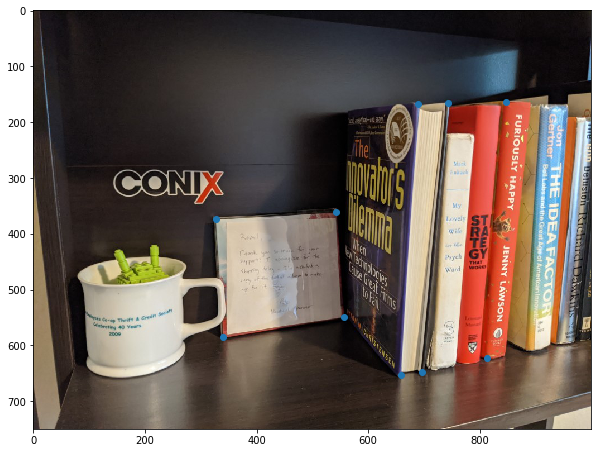

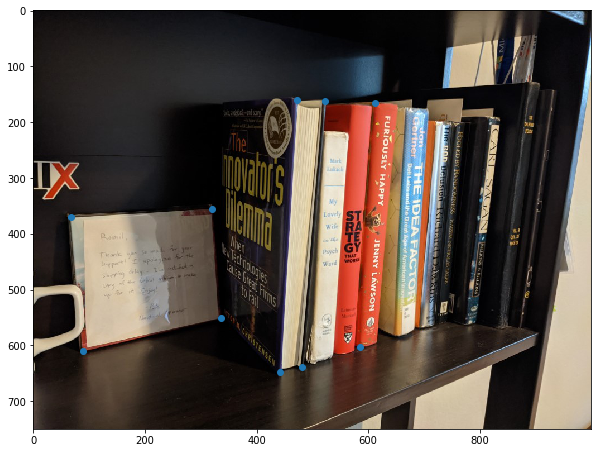

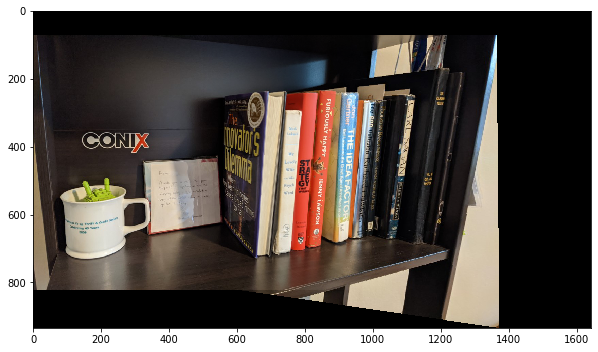

In [64]:
img_name = "shelf"
img1, kps1 = read_img_and_keypoints(f'imgs/{img_name}1.jpg')
plt.figure(figsize=[10,10])
plt.imshow(img1)
plt.scatter(x=kps1[:,0], y=kps1[:,1])
plt.savefig(f'outputs/annotated_{img_name}1.jpg', bbox_inches='tight')

img2, kps2 = read_img_and_keypoints(f'imgs/{img_name}2.jpg')
plt.figure(figsize=[10,10])
plt.imshow(img2)
plt.scatter(x=kps2[:,0], y=kps2[:,1])
plt.savefig(f'outputs/annotated_{img_name}2.jpg', bbox_inches='tight')

H = compute_homography(kps1, kps2)
mos = mosaic(img1, img2, H)
plt.figure(figsize=[10,10])
plt.imshow(mos)
skio.imsave(f'outputs/{img_name}_mosaic.jpg', mos)

## Rectification example

<ipython-input-5-7b2dc8722018>:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  H_arr = (np.linalg.lstsq(coeff_mat, out_mat)[0]).T[0]
<ipython-input-40-6995e98b0604>:14: UserWarning: outputs/shelf_rectified.jpg is a low contrast image
  skio.imsave(f'outputs/{img_name}_rectified.jpg', res)
Lossy conversion from int32 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


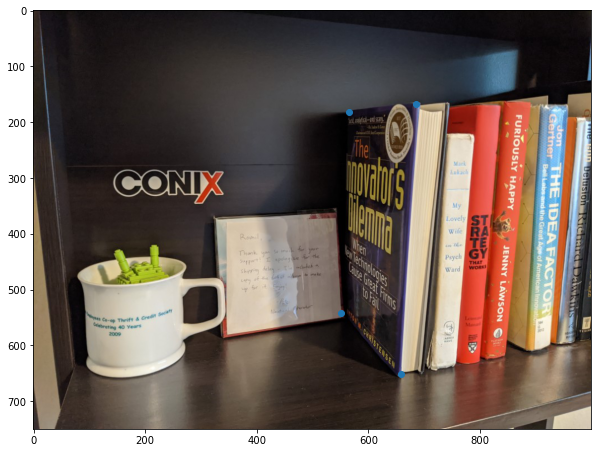

In [40]:
# Read image
img_name = "shelf"
img, kps = read_img_and_keypoints(f'imgs/{img_name}1.jpg', csv_suffix="_rectify")
plt.figure(figsize=[10,10])
plt.imshow(img)
plt.scatter(x=kps[:,0], y=kps[:,1])
plt.savefig(f'outputs/{img_name}_rectificationpts.jpg', bbox_inches='tight')

target_kps = [[0,0], [400,0], [0,400], [400,400]]
target_kps = np.array(target_kps, dtype=np.int)
H = compute_homography(target_kps, kps)

res = mosaic(np.zeros([400,400,3]),img, H, do_blend=False)
skio.imsave(f'outputs/{img_name}_rectified.jpg', res)

# Part B



### Detecting corner features

## Corner detection and ANMS

In [7]:
from harris import get_harris_corners
from skimage.color import rgb2gray

def anms(h_image, points, desired_pts, start_radius = 10, r_increment=7):
    anms_pts = points.copy()
    start_size = len(anms_pts)
    last_size = start_size
    r = start_radius
    while desired_pts < len(anms_pts):
        candidate_pts = []
        while anms_pts.size > 0:
            start_pt = anms_pts[0]
            start_pt_x, start_pt_y = anms_pts[0][0], anms_pts[0][1]
            roi = h_image[start_pt_x-r : start_pt_x+r, start_pt_y-r:start_pt_y+r]
            if roi.size == 0:
                coords_remove = start_pt
                coords_maximal = start_pt
            else:
                coords_maximal = np.array(np.where(roi == np.max(roi))).ravel() - r + start_pt
                x_remove, y_remove = np.mgrid[start_pt_x-r:start_pt_x+r, start_pt_y-r:start_pt_y+r]
                coords_remove = np.vstack([x_remove.ravel(), y_remove.ravel()]).T
            candidate_pts.append(coords_maximal)
            # Invert the coordinates which have been removed to retain the orig anms points.
            points_buf_idx = np.bitwise_not((anms_pts[:, None] == coords_remove).all(-1).any(-1))
            anms_pts = anms_pts[points_buf_idx]
        anms_pts = np.array(candidate_pts.copy())
        r += r_increment
        print(f"Reduced num_points from {last_size} -> {len(anms_pts)}")
    print(f"Overall reduced num_points from {start_size} -> {len(anms_pts)}")
    return anms_pts

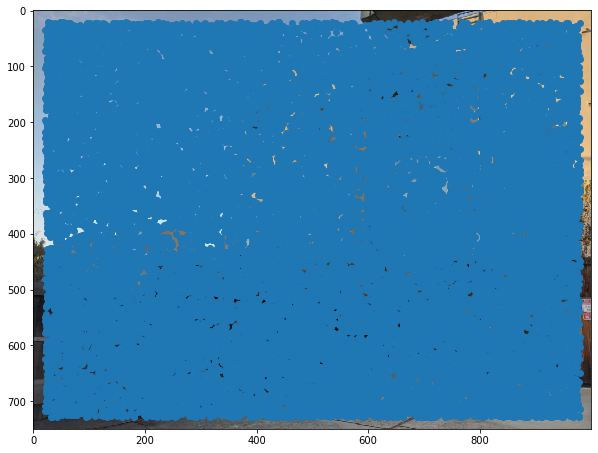

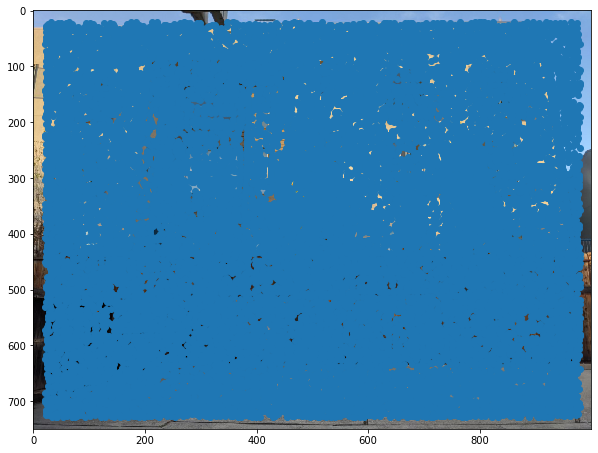

In [65]:
EDGE_DISCARD = 20

img_name = "out"
img1, manual_kps1 = read_img_and_keypoints(f'imgs/{img_name}1.jpg')
img_gray1 = rgb2gray(img1)
h1, harris_coords1 = get_harris_corners(img_gray1, EDGE_DISCARD)

plt.figure(figsize=[10,10])
plt.imshow(img1)
plt.scatter(x=harris_coords1[1,:], y=harris_coords1[0,:])
plt.savefig(f'outputs/{img_name}_harris1.jpg', bbox_inches='tight')

img2, manual_kps2 = read_img_and_keypoints(f'imgs/{img_name}2.jpg')
img_gray2 = rgb2gray(img2)
h2, harris_coords2 = get_harris_corners(img_gray2, EDGE_DISCARD)

plt.figure(figsize=[10,10])
plt.imshow(img2)
plt.scatter(x=harris_coords2[1,:], y=harris_coords2[0,:])
plt.savefig(f'outputs/{img_name}_harris2.jpg', bbox_inches='tight')

In [66]:
# Do ANMS
anms_pts2 = anms(h2, harris_coords2.T, 500)
anms_pts1 = anms(h1, harris_coords1.T, 500)

Reduced num_points from 17990 -> 3423
Reduced num_points from 17990 -> 938
Reduced num_points from 17990 -> 420
Overall reduced num_points from 17990 -> 420
Reduced num_points from 18213 -> 3428
Reduced num_points from 18213 -> 943
Reduced num_points from 18213 -> 424
Overall reduced num_points from 18213 -> 424


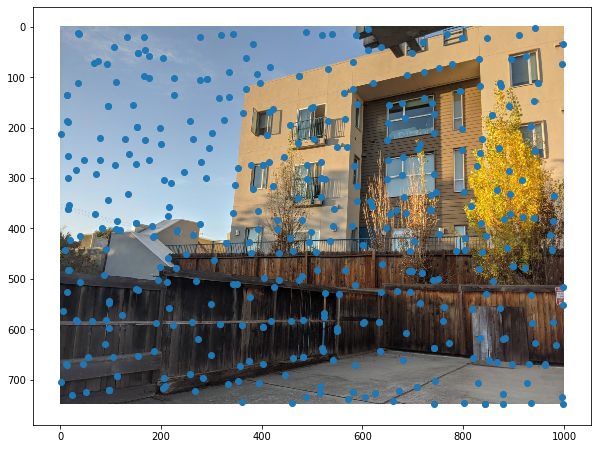

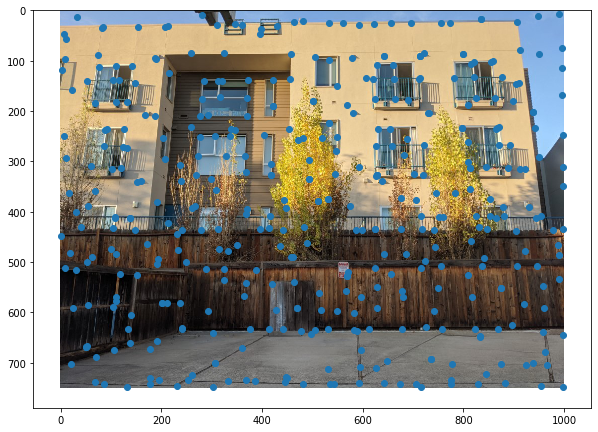

In [44]:
plt.figure(figsize=[10,10])
plt.imshow(img1)
plt.scatter(x=anms_pts1[:,1], y=anms_pts1[:,0])
plt.savefig(f'outputs/{img_name}_anms1.jpg', bbox_inches='tight')

plt.figure(figsize=[10,10])
plt.imshow(img2)
plt.scatter(x=anms_pts2[:,1], y=anms_pts2[:,0])
plt.savefig(f'outputs/{img_name}_anms2.jpg', bbox_inches='tight')

## Methods to compute features

In [45]:
from scipy.signal import convolve2d
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

def get_patches(image, points, size=40):
    patches = []
    offset = int(size/2)
    for point in points:
        start_x, end_x = point[1] - offset, point[1] + offset
        start_y, end_y = point[0] - offset, point[0] + offset
        if start_y < 0 or start_x < 0 or end_y > image.shape[0] or end_x > image.shape[1]:
            # Skip points which dont exceed boundaries
            continue
        patch = image[start_y:end_y, start_x:end_x]
        patches.append([patch, point])
    return patches

def get_features(patches, blur_sigma = 3, patch_resize = 8):
    feat_patches = []
    for patch, point in patches:
        blurred_patch = gaussian_filter(patch, sigma=blur_sigma)
        resized_patch = resize(blurred_patch, (patch_resize, patch_resize))
        # Normalize the patch
        norm_patch = (resized_patch - np.mean(resized_patch))/np.std(resized_patch)
        feat_patches.append((norm_patch, point))
    return feat_patches

def get_correspondences(feat_patches1, feat_patches2):
    feature_map = {}
    pts1_ordered = []
    pts2_ordered = []
    for i, [patch1, point1] in enumerate(feat_patches1):
        NNs = []
        for j, [patch2, point2] in enumerate(feat_patches2):
            ssd = np.sum(np.sum((patch2-patch1)**2))
            NNs.append([ssd, point1, point2])
        NNs.sort(key = lambda x: x[0])
        ratio = NNs[0][0] / NNs[1][0]  # Compare 1-nearest and 2-nearest
        if ratio < 0.2:
            pts1_ordered.append(NNs[0][1])
            pts2_ordered.append(NNs[0][2])
    return convert_pts(np.array(pts1_ordered)), convert_pts(np.array(pts2_ordered))

def convert_pts(pts):
    pts[:, [0, 1]] = pts[:, [1, 0]]
    return pts

In [46]:
# Get patches and create mapping
patches1 = get_patches(img_gray1, anms_pts1)
feature_patches1 = get_features(patches1)
patches2 = get_patches(img_gray2, anms_pts2)
feature_patches2 = get_features(patches2)
pts1_ordered, pts2_ordered = get_correspondences(feature_patches1, feature_patches2)

(30, 2)


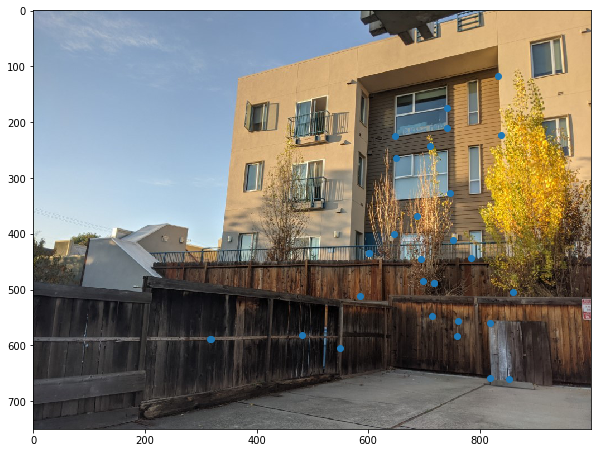

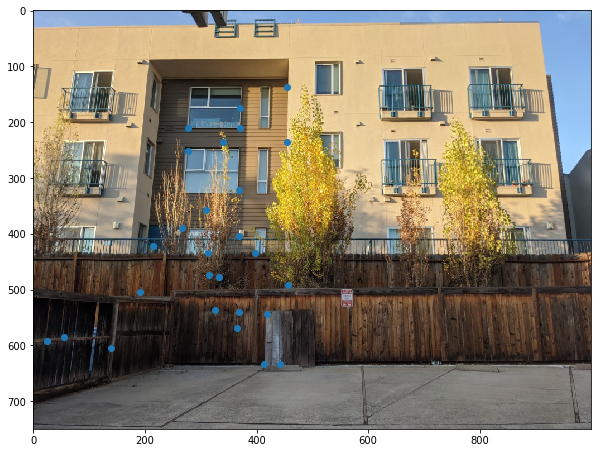

In [47]:
# Visualize matched points
print(pts1_ordered.shape)

plt.figure(figsize=[10,10])
plt.imshow(img1)
plt.scatter(x=pts1_ordered[:,0], y=pts1_ordered[:,1])
plt.savefig(f'outputs/{img_name}_featmatched1.jpg', bbox_inches='tight')

plt.figure(figsize=[10,10])
plt.imshow(img2)
plt.scatter(x=pts2_ordered[:,0], y=pts2_ordered[:,1])
plt.savefig(f'outputs/{img_name}_featmatched2.jpg', bbox_inches='tight')

#### RANSAC code

In [48]:
def ransac(pts1, pts2, num_iters = 100, ransac_pts = 4):
    distances = []
    num_pts = pts1.shape[0]
    for i in range(num_iters):
        random_indices = np.random.choice(num_pts, size=ransac_pts, replace=False)
        ransac_pts1 = pts1[random_indices, :]
        ransac_pts2 = pts2[random_indices, :]
        H = compute_homography(ransac_pts1, ransac_pts2)
        inliers = 0
        best_config = {'inliers': 0, 'H': None}
        for idx in range(num_pts):
            p = np.array([[pts1[idx,0]], [pts1[idx,1]], [1]])
            target_p = np.array([[pts2[idx,0]], [pts2[idx,1]], [1]])
            transformed_p = np.matmul(H, target_p)
            transformed_p = transformed_p / transformed_p[2]
            transformed_p = np.array(transformed_p[:2].flatten()).reshape(1, 2)
            distance = np.linalg.norm(transformed_p-pts1[idx,:])
            distances.append(distance)
            if int(distance) < 2:
                inliers += 1
        if inliers > best_config['inliers']:
            best_config = {'inliers': inliers, 'H': H}
    return best_config

In [49]:
best_config = ransac(pts1_ordered, pts2_ordered, num_iters = 1000)

/mnt/d/wsl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


In [50]:
print(best_config)

{'inliers': 20, 'H': array([[ 4.54754823e-01,  5.56815640e-02,  4.10555434e+02],
       [-2.67442970e-01,  8.37830849e-01,  8.88723535e+01],
       [-5.48161909e-04,  2.38477904e-06,  1.00000000e+00]])}


/mnt/d/wsl/anaconda3/lib/python3.7/site-packages/skimage/io/_io.py:141: UserWarning: outputs/out_mosaic_auto.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.


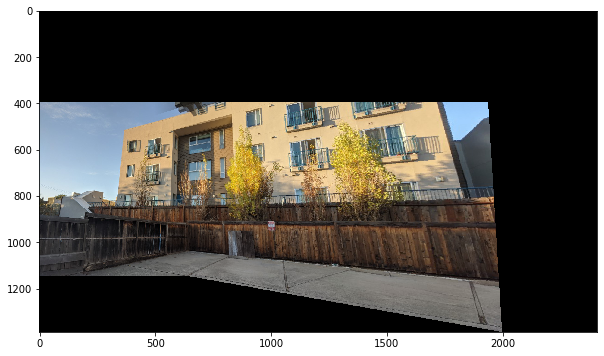

In [51]:
H=best_config['H']
mos = mosaic(img1, img2, H)
plt.figure(figsize=[10,10])
plt.imshow(mos)
skio.imsave(f'outputs/{img_name}_mosaic_auto.jpg', mos)